In [2]:
using Pkg
using Revise

Pkg.activate("..")

# Pkg.update("FoodWebs")

using CairoMakie
using NetworkLayout
using GraphMakie, Graphs, MetaGraphs
using ColorSchemes

using FoodWebs
using LinearAlgebra
using StatsBase, Polynomials
using JLD2

using DelimitedFiles

using ProfileVega


fw = FoodWebs

  Activating project at `~/Projects/Working/HIFMB/TempRanges`


FoodWebs

# Introduction

In this notebook I will outline the simulation steps looking at the effects of shifts in species ranges with climate change. First I will describe the simulation procedure and then show some results. 

# Methods

Simulations are done as follows:

1. Generate a global pool of species with traits for body size $n$ and a thermal preference $0 < T_{pk} < 1$
2. Assemble $M$ stable communties using the niche model to generate their structure and the generalised modeling approach to ensure the proportion of stable webs (psw) is above some threshold. Each community has a temperature value $T$ and species are sampled so they are within some range of their respecitve preaks $T_{\text{range}}$.
3. Disperse species between communties according to one of two methods:
    1.  __Weighted__: Species disperse with a probability proportional to their body size $p_{d,i}(d) \propto n_i$. The communtiy to disperse to is sampled by weighting all communties with $e^{-2\lambda_i T_{\text{diff}}}$ where $T_{\text{diff}}$ is the difference in temperature between the two communties and $\lambda_i = (1 - n)^{0.75}$ is determined by body size. 
    2. __Random__: Species are selected randomly and disperse to all other communtities with uniform probability.

In [3]:
#1) GENERATE SPECIES POOL
N_pool = 25
@time sp_vec = fw.species(0.1, N_pool);

  1.029644 seconds (2.05 M allocations: 103.149 MiB, 30.93% gc time, 99.94% compilation time: 1% of which was recompilation)


In [4]:
using Distributions

function exp_parameters(N::Int64, M::Int64)
    #exponent
    γ = rand(Uniform(0.8, 1.5), N, M) #[0.8, 1.5]
    λ = ones(N,N) # 1
    μ = rand(Uniform(1.0, 2.0), N, M) #[1.0, 2.0] 
    ϕ = rand(Uniform(0.0, 1.0), N, M) #[0.0, 1.0]
    ψ = rand(Uniform(0.5,1.1), N, M) #[0.5, 1.2]

    return [fw.ExponentialParameters(γ[:,i], λ, μ[:,i], ϕ[:,i], ψ[:,i]) for i = 1:M]
end

exp_parameters(com::fw.Community, M::Int64) = exp_parameters(com.N, M)

exp_parameters (generic function with 2 methods)

In [5]:
Nvec = [10,20,30,40,50]
Nrep = 500
psw = zeros(Nrep, length(Nvec))
# coms = Array{fw.Community, 1}(undef, Nrep)

for (i,N) in enumerate(Nvec)
    print(N)
    for j = 1:Nrep
        sp_vec = fw.species(0.2, N, n = rand(N));
        coms = fw.community(sp_vec)
        psw[j, i] = fw.proportion_stable_webs(coms, N_trials = 100, f_ep = exp_parameters)
    end
end

1020304050

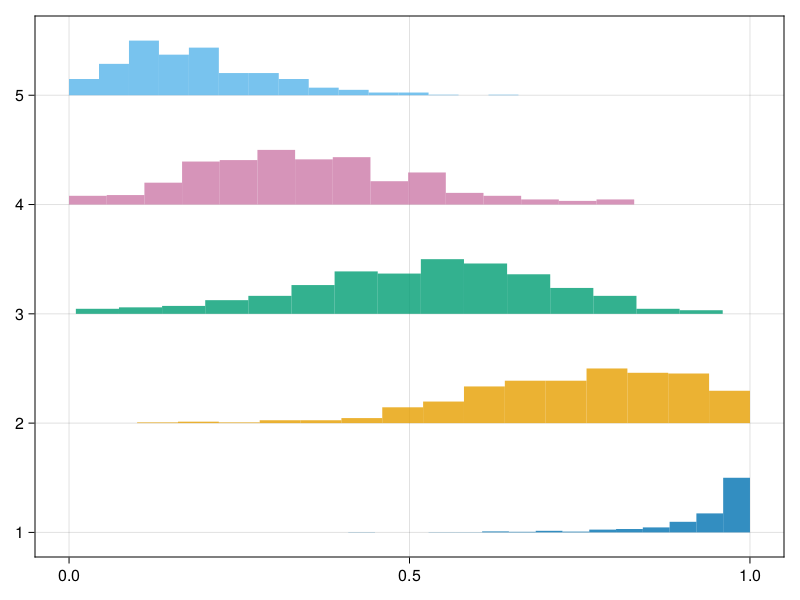

In [6]:
fig = Figure()
ax = Axis(fig[1,1])

for i = eachindex(Nvec)
    hist!(ax, psw[:,i], offset = i,  scale_to=0.5)

end

fig

In [7]:
#3) DISPERSAL
# # FoodWebs.K_dispersals!(mc1,10)
# N_dispersal = 2
# N_rep = 100
# N_trials = 10

# res = zeros(N_T, N_dispersal,N_rep,2,N_trials)
# params = Array{fw.GeneralisedParameters, 5}(undef, N_T, N_dispersal,N_rep,2,N_trials)
# bodysize = Array{Vector{Float64},4}(undef, N_T, N_dispersal,N_rep,2)

# Threads.@threads for r = 1:N_rep
#     mc_prob,mc_random = generate_mc(sp_vec)
    
#     for d = 1:N_dispersal
#         #probabablistic
#         for (i,c) = enumerate(mc_prob.coms)
#             #itterate for given web structure
#             for trial = 1:N_trials
#                 p = fw.generalised_parameters(c)
#                 J = similar(p.A)
#                 fw.generalised_jacobian!(J,p)
#                 res[i,d,r,1,trial] = fw.max_real_eigval(J) 
#                 params[i,d,r,1,trial] = deepcopy(p)
#             end
#         end
        
#         #random
#         for (i,c) = enumerate(mc_random.coms)
#             #itterate for given web structure
#             for trial = 1:N_trials
#                 p = fw.generalised_parameters(c)
#                 J = similar(p.A)
#                 fw.generalised_jacobian!(J,p)
#                 res[i,d,r,2,trial] = fw.max_real_eigval(J) 
#                 params[i,d,r,2,trial] = deepcopy(p)
#             end
#         end
        
#         bodysize[:,d,r,1] .= get_M.(mc_prob.coms)
#         bodysize[:,d,r,2] .= get_M.(mc_random.coms)


#         fw.multiple_dispersal!(mc_prob, p_dispersal = :p, d_dispersal = :p)
#         fw.multiple_dispersal!(mc_random, p_dispersal = :r, d_dispersal = :r)

#         if d % 100 == 0
#             print(i)
#         end
#     end
# end

# # save("simulations.jld2", Dict("res" => res, "params" => params, "bodysize" => bodysize))

# Results

## main results

In [10]:
time = repeat([0,1], inner = 50, outer = 2)
treatment = repeat([0,1], inner = 100)

mean_log(x) = mean(map(log, x))

for N = 1
    for C = 1
        for a = 1
            for chunk = 1:10
                println(C, a, chunk)
                fn = join(["../Data/psw_test/simulations_",N,"_",C,"_",a,"_",chunk,".jld2"])
                r = load(fn)

                N_mat = length.(r["bodysize"])
                N_mat = vcat(N_mat[:,:,1,1], N_mat[:,:,1,2],N_mat[:,:,2,1],N_mat[:,:,2,2])
                N_mat = hcat(time, treatment, N_mat)

                bs_mat = mean_log.((r["bodysize"]))
                bs_mat = vcat(bs_mat[:,:,1,1], bs_mat[:,:,1,2],bs_mat[:,:,2,1],bs_mat[:,:,2,2])
                bs_mat = hcat(time, treatment, bs_mat)

                psw_mat = r["psw"]
                psw_mat = vcat(psw_mat[:,:,1,1], psw_mat[:,:,1,2],psw_mat[:,:,2,1],psw_mat[:,:,2,2])
                psw_mat = hcat(time, treatment, psw_mat)


                fn_N = join(["../Data/psw_test_csv/N_simulation_",N,"_",C,"_",a,"_",chunk,".csv"])
                fn_bs = join(["../Data/psw_test_csv/bs_simulation_",N,"_",C,"_",a,"_",chunk,".csv"])
                fn_psw = join(["../Data/psw_test_csv/psw_simulation_",N,"_",C,"_",a,"_",chunk,".csv"])


                writedlm(fn_N, N_mat)
                writedlm(fn_bs, bs_mat)
                writedlm(fn_psw, psw_mat)
            end
        end
    end
end

111
112
113
114
115
116
117
118
119
1110


## Multiple simulations

In [9]:
time = repeat([0,1], inner = 50, outer = 2)
treatment = repeat([0,1], inner = 100)

for N = 1:3
    for C = 1:3
        for a = 1:5
            for chunk = 1:5
                println(C, a, chunk)
                fn = join(["../Data/psw_sensitvity/simulations_",N,"_",C,"_",a,"_",chunk,".jld2"])
                r = load(fn)

                N_mat = length.(r["bodysize"])
                N_mat = vcat(N_mat[:,:,1,1], N_mat[:,:,1,2],N_mat[:,:,2,1],N_mat[:,:,2,2])
                N_mat = hcat(time, treatment, N_mat)

                bs_mat = mean.(r["bodysize"])
                bs_mat = vcat(bs_mat[:,:,1,1], bs_mat[:,:,1,2],bs_mat[:,:,2,1],bs_mat[:,:,2,2])
                bs_mat = hcat(time, treatment, bs_mat)

                psw_mat = r["psw"]
                psw_mat = vcat(psw_mat[:,:,1,1], psw_mat[:,:,1,2],psw_mat[:,:,2,1],psw_mat[:,:,2,2])
                psw_mat = hcat(time, treatment, psw_mat)


                fn_N = join(["../Data/psw_sensitvity_csv/N_simulation_",N,"_",C,"_",a,"_",chunk,".csv"])
                fn_bs = join(["../Data/psw_sensitvity_csv/bs_simulation_",N,"_",C,"_",a,"_",chunk,".csv"])
                fn_psw = join(["../Data/psw_sensitvity_csv/psw_simulation_",N,"_",C,"_",a,"_",chunk,".csv"])


                writedlm(fn_N, N_mat)
                writedlm(fn_bs, bs_mat)
                writedlm(fn_psw, psw_mat)
            end
        end
    end
end

111
112
113
114
115
121
122
123
124
125
131
132
133
134
135
141
142
143
144
145
151
152
153
154
155
211
212
213
214
215
221
222
223
224
225
231
232
233
234
235
241
242
243
244
245
251
252
253
254
255
311
312
313
314
315
321
322
323
324
325
331
332
333
334
335
341
342
343
344
345
351
352
353
354
355
111
112
113
114
115
121
122
123
124
125
131
132
133
134
135
141
142
143
144
145
151
152
153
154
155
211
212
213
214
215
221
222
223
224
225
231
232
233
234
235
241
242
243
244
245
251
252
253
254
255
311
312
313
314
315
321
322
323
324
325
331
332
333
334
335
341
342
343
344
345
351
352
353
354
355
111
112
113
114
115
121
122
123
124
125
131
132
133
134
135
141
142
143
144
145
151
152
153
154
155
211
212
213
214
215
221
222
223
224
225
231
232
233
234
235
241
242
243
244
245
251
252
253
254
255
311
312
313
314
315
321
322
323
324
325
331
332
333
334
335
341
342
343
344
345
351
352
353
354
355


In [99]:
#turnover
function jacc(id1,id2; method = :total)
    if method == :total
        return(length(intersect(id1,id2)) / length(union(id1,id2)))
    elseif method == :new
        return( sum(.!in.(id1, Ref(id2))) / length(union(id1,id2)) )
    elseif method == :out
        return( sum(.!in.(id2, Ref(id1))) / length(union(id1,id2)) )
    end
end

jacc (generic function with 1 method)

# Results

Here we have the results from the simulations. Across the communties we see a clear pattern of stability in the allometric (i.e. constrained) and the random dispersal. 

The allometric generally shows reduced stability at higher lattitudes presumably because of the influx more species.

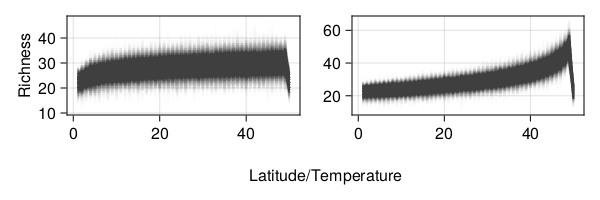

In [100]:
#richness
fig = Figure(resolution = (600,200))

ax = Axis(fig[1,1], ylabel = "Richness")
series!(ax, N_mat[:,:,1,2]', solid_color = (:black, 0.01))

ax = Axis(fig[1,2])
series!(ax, N_mat[:,:,2,2]', solid_color = (:black, 0.01))

Label(fig[2,1:2], "Latitude/Temperature")

fig

In [93]:
# #turnover - use bs as proxy for now
# res_bs = r["bodysize"]
# turnover = zeros(N_T, N_rep, 2)

# for r = 1:N_rep
#     for p = 1:2
#         turnover[:,r,p,1] .= [jacc(res_bs[T,r,p,1], res_bs[T,r,p,2], method = :total) for T = 1:N_T]
#     end
# end

# fig = Figure(resolution = (600,200))

# ax = Axis(fig[1,1])
# series!(ax, turnover[:,:,1], solid_color = (:black, 0.1))

# ax = Axis(fig[1,2])
# series!(ax, turnover[:,:,2], solid_color = (:black, 0.1))

# fig

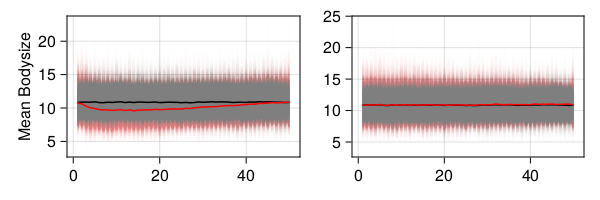

In [107]:
#bodysize
fig = Figure(resolution = (600,200))
ax = Axis(fig[1,1], ylabel = "Mean Bodysize")
series!(ax, bs_mat[:,:,1,1]', solid_color = (:black, 0.005))
series!(ax, bs_mat[:,:,1,2]', solid_color = (:red, 0.005))

lines!(ax,1:N_T, bs_mean[:,1,1,1], color = :black)
lines!(ax,1:N_T, bs_mean[:,1,1,2], color = :red)

ax = Axis(fig[1,2])
series!(ax, bs_mat[:,:,2,1]', solid_color = (:black, 0.005))
series!(ax, bs_mat[:,:,2,2]', solid_color = (:red, 0.005))

lines!(ax,1:N_T, bs_mean[:,1,2,1], color = :black)
lines!(ax,1:N_T, bs_mean[:,1,2,2], color = :red)

linkaxes!.(fig.content)

fig


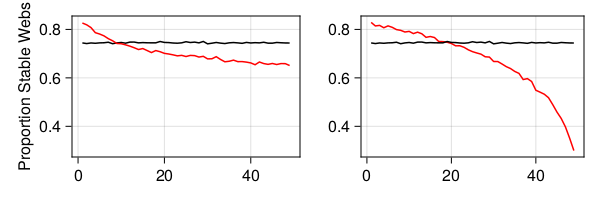

In [102]:
#psw
fig = Figure(resolution = (600,200))
ax = Axis(fig[1,1], ylabel="Proportion Stable Webs")

T_lim = 1:N_T-1

# series!(ax, 1:N_T, psw_mat[:,:,1,1]', solid_color = (:black, 0.01))
# series!(ax, 1:N_T, psw_mat[:,:,1,2]', solid_color = (:red, 0.01))

lines!(ax,T_lim, mean(psw_mat, dims = 2)[T_lim,1,1,1], color = :black)
lines!(ax,T_lim, mean(psw_mat, dims = 2)[T_lim,1,1,2], color = :red)


ax = Axis(fig[1,2])
# series!(ax, 1:N_T, psw_mat[:,:,2,1]', solid_color = (:black, 0.01))
# series!(ax, 1:N_T, psw_mat[:,:,2,2]', solid_color = (:red, 0.01))

lines!(ax,T_lim, mean(psw_mat, dims = 2)[T_lim,1,2,2], color = :red)
lines!(ax,T_lim, mean(psw_mat, dims = 2)[T_lim,1,2,1], color = :black)


linkaxes!(fig.content...)

fig

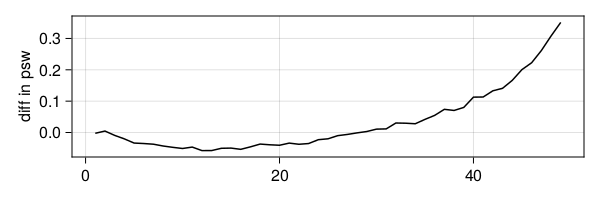

In [103]:
fig = Figure(resolution = (600,200))
ax = Axis(fig[1,1], ylabel = "diff in psw")

lines!(ax,T_lim, mean(psw_mat, dims = 2)[T_lim,1,1,2] .- mean(psw_mat, dims = 2)[T_lim,1,2,2], color = :black)

fig

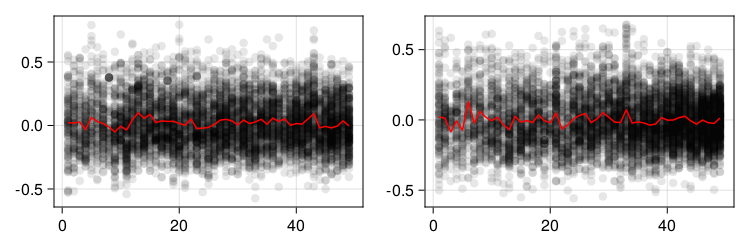

In [22]:
#types of instability
cor_mat = fill(Float64[], N_T-1, N_rep, 2)

for i = 1:2
    for T = T_lim
        for rep = 1:N_rep
            #get values
            λvals = real.(r["vals"][T,rep,i,2])

            unstable = findall(λvals .>= 0)

            if length(unstable) > 0
                unstable_vecs = norm.(r["vecs"][T,rep,i,2][unstable, :])
                bs_vec = r["bodysize"][T,rep,i,2]

                cor_mat[T,rep,i] = mapslices(x -> cor(x,bs_vec) , unstable_vecs, dims = 2)[:]
            end
        end
    end
end

fig = Figure(resolution = (750,250))
ax1 = Axis(fig[1,1])
ax2 = Axis(fig[1,2])

for T = T_lim
    for rep = 1:N_rep
        if length(cor_mat[T,rep,1]) > 0
            scatter!(ax1, fill(T, length(cor_mat[T,rep,1])), cor_mat[T,rep,1], color = (:black, 0.1))
        end
        
         if length(cor_mat[T,rep,2]) > 0
            scatter!(ax2, fill(T, length(cor_mat[T,rep,2])), cor_mat[T,rep,2], color = (:black, 0.1))
        end
        
    end
end

cor_mean = map(x -> mean(filter(!isnan,x)), cor_mat)
cor_mean = mapslices(x -> mean(filter(!isnan,x)), cor_mean, dims = 2)

lines!(ax1, T_lim, cor_mean[:,1,1], color = "red")
lines!(ax2, T_lim, cor_mean[:,1,2], color = "red")

fig

# Foodweb Plotting

In [221]:
function foodweb_layout(g)
    ny = 1 .- g.gprops[:n]
    nx = rand(length(g.gprops[:n]))
    return(Point.(zip(nx, ny)))
end

foodweb_layout (generic function with 1 method)

In [222]:
#plotting
stable_coms = [communities[i,x[2]] for (i,x) = enumerate(stable_indx)]

#convert to graphs
g_vec = Vector{Any}(undef, N_temp)
for (i,sc) = enumerate(stable_coms)
    g = MetaDiGraph(SimpleDiGraph(sc.A))
    set_prop!(g, :n, [x.n for x = sc.sp])
    
    g_vec[i] = g
end

LoadError: UndefVarError: stable_indx not defined

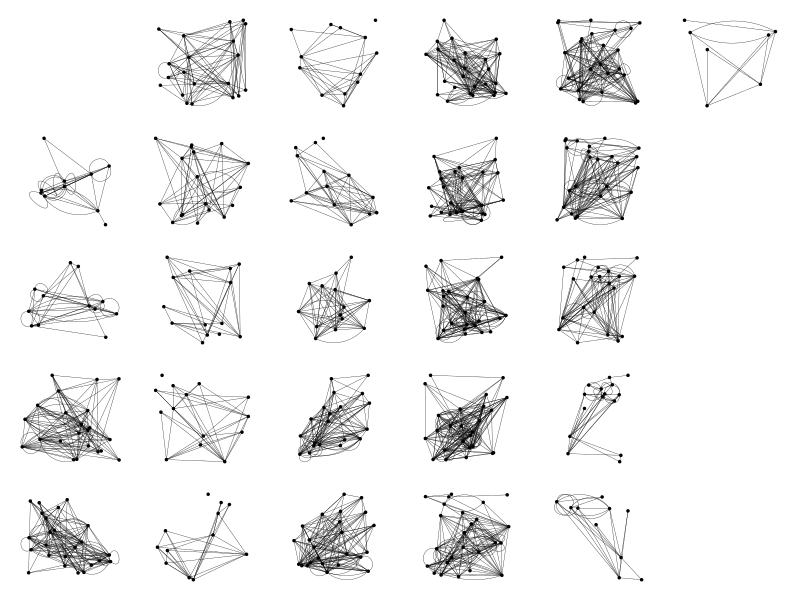

In [53]:
f = Figure()

ax = [Axis(f[i % 5,(i ÷ 5)]) for i = 1:N_temp]

[graphplot!(ax[i],g_vec[i], layout=foodweb_layout, edge_width = 0.3, arrow_size = 0.0, node_size = 5) for i = 1:N_temp]
hidedecorations!.(ax); hidespines!.(ax)
[ax[i].aspect = DataAspect() for i = 1:N_temp]

f

In [54]:
#calculate sp_occurance
result = Vector{Any}(undef, length(sp_vec))
id_sp = Dict{Base.UUID,Vector{Any}}()

for i = CartesianIndices(stable_coms)
    for s = communities[i].sp
        if s.id in keys(id_sp)
            push!(id_sp[s.id], i)
        else
            id_sp[s.id] = [i]
        end
    end
end
